In [192]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing import Preprocessing
from utils.results import compute_rsquared
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [193]:
TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.9 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [194]:
data, all_gdps, all_gts = load_data()

In [195]:
search_terms = [col for col in all_gts.columns if col.endswith('_average')]

processed_gts = all_gts.copy() # Monthly Google Trends
processed_gts['date'] = pd.to_datetime(processed_gts['date'])
processed_gts[search_terms] = np.log(processed_gts[search_terms] + 1)

# for nb_quarters in range(1, 3 * 3):
#     diff = (processed_gts[search_terms] - processed_gts.groupby("country")[search_terms].diff(nb_quarters * 3)).add_suffix(f'_{nb_quarters}q_diff')
#     processed_gts = pd.concat([processed_gts, diff], axis=1)

for nb_years in range(1, 3): # 3 will add 2 years difference
    diff = (processed_gts[search_terms] - processed_gts.groupby("country")[search_terms].diff(nb_years * 12)).add_suffix(f'_{nb_years}y_diff')
    processed_gts = pd.concat([processed_gts, diff], axis=1)

processed_gts.drop(columns=search_terms, inplace=True)


In [196]:
print(f"Data shape: {data.shape}")

data['date'] = pd.to_datetime(data['date'])
processed_gts = processed_gts.dropna()
data_merged = data.merge(processed_gts, left_on=["country", "date"], right_on=["country", "date"], how="left")
data_merged['date'] = pd.to_datetime(data_merged['date']).dt.strftime('%Y-%m-%d')

print(f"Data merged shape: {data_merged.shape}")

Data shape: (550, 97)
Data merged shape: (550, 285)


In [197]:
data_dt = data_merged.copy()
data_dt['date'] = pd.to_datetime(data_dt['date'])
splitting_date = data_dt['date'].quantile(TRAIN_PROPORTION)


In [198]:
preprocessor = Preprocessing(data=data_merged, epsilon=EPS, mode=MODE, past_GDP_lags=PAST_GDPS, diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)
X_train, y_train, X_valid, y_valid = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, shuffle=False, splitting_date=splitting_date)

X_train[preprocessor.country_train == "Switzerland"].head()



X_train shape : (438, 292)
X_valid shape : (60, 292)
y_train shape : (438,)
y_valid shape : (60,)


,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,Credit_average,...,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States,month_3,month_6,month_9,month_12
4,0.035926,-1.589690,-1.889848,1.205852,-1.331198,0.707219,-0.610806,1.417080,-1.077500,0.811169,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,1.0,0.0,0.0,0.0
10,-0.017415,-1.519000,-1.889848,1.105522,-1.514042,-1.083470,-0.610806,0.652095,-1.343835,1.034876,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,1.0,0.0,0.0
16,0.462658,-1.306930,-1.889848,1.138965,-1.392146,-0.864760,-0.610806,0.860727,-0.988722,0.721686,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,0.0,1.0,0.0
20,-1.297609,-1.589690,-1.889848,1.038635,-1.574990,-1.138147,-0.610806,0.721639,-1.432613,1.079618,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,0.0,0.0,1.0
28,-0.017415,-1.236239,-1.889848,1.306181,-1.453094,0.898590,-0.610806,1.208448,-1.343835,1.392808,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,1.0,0.0,0.0,0.0


In [199]:
# Print all columns that contain Research_and_development
search_term = "Research_and_development"
search_cols = [col for col in X_train.columns if search_term in col]
other_cols = []
X_train[preprocessor.country_train == "Switzerland"][search_cols + other_cols].head()

,Research_and_development_average,Research_and_development_average_1y_diff,Research_and_development_average_2y_diff
4,-1.589690,-0.291910,-6.392120
10,-1.519000,-7.792997,-6.392120
16,-1.306930,-7.792997,-6.392120
20,-1.589690,-0.722410,-0.118996
28,-1.236239,-1.714881,-0.271314


Explained variance ratio: 0.9956449529909496


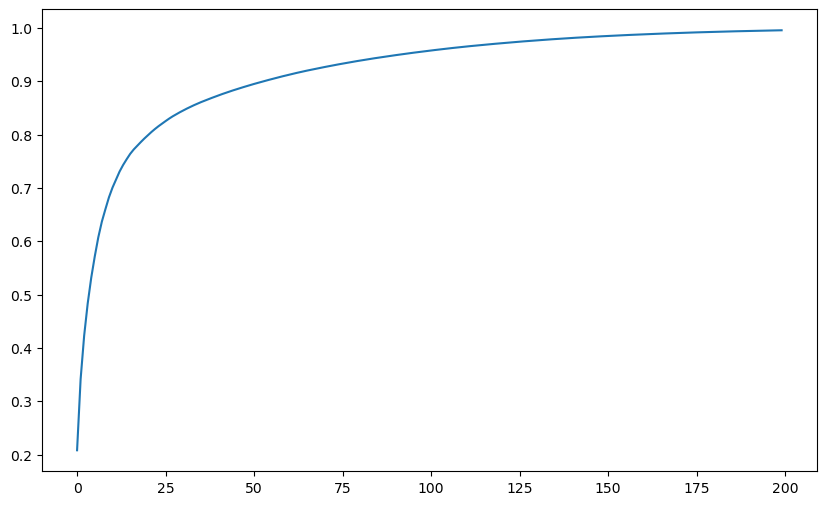

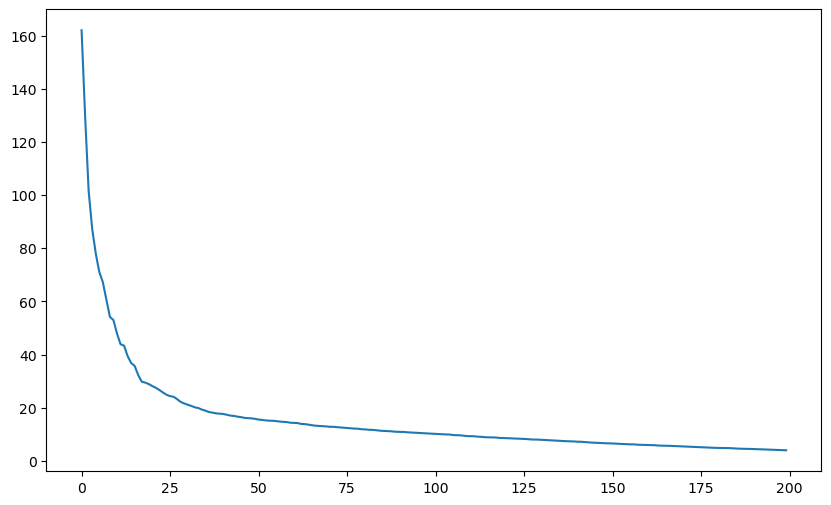

In [ ]:
# Apply PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

pca = PCA(150)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum()}")
plot.figure(figsize=(10, 6))
plot.plot(np.cumsum(pca.explained_variance_ratio_))

# Plot singular values
plot.figure(figsize=(10, 6))
plot.plot(pca.singular_values_)
plot.show()

In [201]:
# x_train = X_train.values
# x_valid = X_valid.values
x_train = X_train_pca
x_valid = X_valid_pca
y_train = y_train.values
y_valid = y_valid.values
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid

## Simple Prediction Model

### We start with a simple regression model

In [202]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [203]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
# Function to set random seed
def set_seed(seed):
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # PyTorch for all GPUs (if multiple GPUs are used)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids non-deterministic optimizations
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=2000, learning_rate=1e-3, weight_decay=1e-3, verbose = True):
    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []
    valid_r_squared = []
    
    epoch_range = tqdm(range(num_epochs)) if verbose else range(num_epochs)
    for t in epoch_range:
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())

        valid_r_squared.append(r_squared)
        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred = model(x_valid_t)

    v_loss = loss_fn(y_pred, y_valid_t)
    validation_loss.append(v_loss.item())
    print(f"Validation loss: {v_loss.item()}")

    t_loss = loss_fn(model(x_train_t), y_train_t)
    training_loss.append(t_loss.item())
    print(f"Training loss: {t_loss.item()}")

    r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
    valid_r_squared.append(r_squared)
    print(f"Validation R^2: {r_squared}")
    
    return model, training_loss, validation_loss, valid_r_squared

In [204]:
model, training_loss, validation_loss, validation_r_squared = train_nn(x_train, y_train, x_valid, y_valid, num_epochs=300, learning_rate=1e-3, weight_decay=5e-2)

  0%|          | 0/300 [00:00<?, ?it/s]

Validation loss: 0.9634519219398499
Training loss: 0.015127546153962612
Validation R^2: 0.03276070387541774


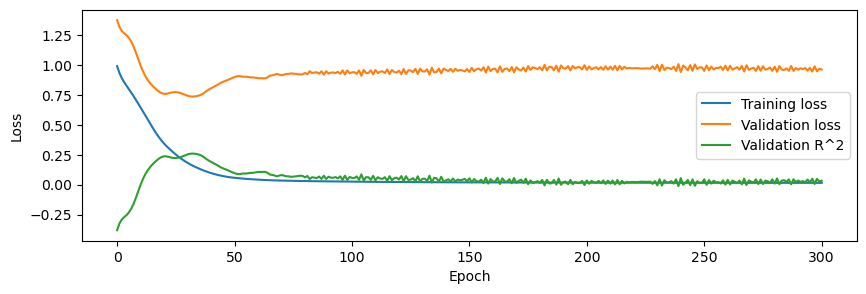

In [205]:
plt.figure(figsize=(10, 3))
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.plot(validation_r_squared, label="Validation R^2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [206]:
# Make bootrapping
n_bootstrap = 250
n = len(x_train)
n_features = x_train.shape[1]

n_countries = len(np.unique(country_train))

bootstrap_size = n // n_countries # np.ceil(150 / n_countries).astype(int)

bootstrap_models = []
mse_bootstrap = np.zeros(n_bootstrap)
rsquared_bootstrap = np.zeros(n_bootstrap)

for i in tqdm(range(n_bootstrap)):
    # Make a bootstrap sample of size bootstrap_size
    set_seed(SEED + i)

    indices_per_country = [np.where(country_train == c)[0] for c in np.unique(country_train)]
    bootstrap_idx = np.concatenate([np.random.choice(indices, size=bootstrap_size, replace=True) for indices in indices_per_country])
    x_train_bootstrap = x_train[bootstrap_idx]
    y_train_bootstrap = y_train[bootstrap_idx]

    model_bootstrap, _, _, _ = train_nn(x_train_bootstrap, y_train_bootstrap, x_valid, y_valid, num_epochs=50, learning_rate=1e-3, weight_decay=5e-2, verbose=False)
    y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

    mse = mean_squared_error(y_valid, y_pred)
    rsquared = compute_rsquared(y_valid, y_pred)

    bootstrap_models.append(model_bootstrap)
    mse_bootstrap[i] = mse
    rsquared_bootstrap[i] = rsquared

# Aggregate the predictions
y_pred = np.zeros((x_valid.shape[0], n_bootstrap))
for i in range(n_bootstrap):
    y_pred[:, i] = bootstrap_models[i](torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

y_pred_mean = np.mean(y_pred, axis=1)
y_pred_std = np.std(y_pred, axis=1)
y_pred_median = np.median(y_pred, axis=1)

# Get the model with the best R squared
best_model_idx = np.argmax(rsquared_bootstrap)
best_model = bootstrap_models[best_model_idx]
best_rsquared = rsquared_bootstrap[best_model_idx]
y_pred_best = best_model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

  0%|          | 0/250 [00:00<?, ?it/s]

Validation loss: 0.7865874171257019
Training loss: 0.0360865443944931
Validation R^2: 0.21032052101243814
Validation loss: 0.7844326496124268
Training loss: 0.026163479313254356
Validation R^2: 0.2124837961023761
Validation loss: 0.8298079371452332
Training loss: 0.03976130113005638
Validation R^2: 0.16693008958845001
Validation loss: 0.939899742603302
Training loss: 0.03651345148682594
Validation R^2: 0.05640554815557386
Validation loss: 0.9725073575973511
Training loss: 0.03500857204198837
Validation R^2: 0.023669787686442567
Validation loss: 0.6923820972442627
Training loss: 0.03215401619672775
Validation R^2: 0.3048962366049558
Validation loss: 0.8907795548439026
Training loss: 0.04120338335633278
Validation R^2: 0.10571889248384181
Validation loss: 0.6208059787750244
Training loss: 0.04140756279230118
Validation R^2: 0.3767536929303422
Validation loss: 0.9292364716529846
Training loss: 0.02717641554772854
Validation R^2: 0.06711079289999267
Validation loss: 0.9152718782424927
Trai

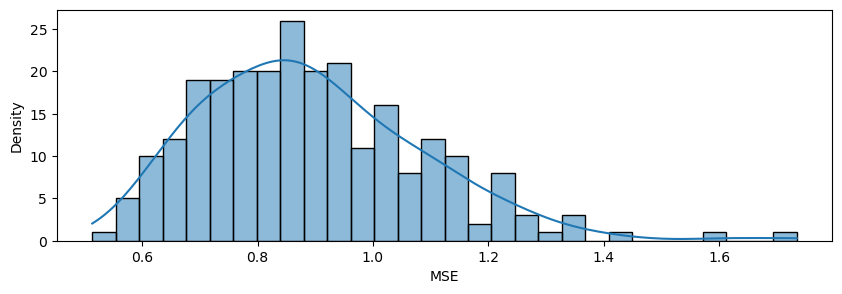

In [207]:
# Plot the MSE
plt.figure(figsize=(10, 3))
sns.histplot(mse_bootstrap, bins=30, kde=True)
plt.xlabel("MSE")
plt.ylabel("Density")
plt.show()

Bootstrapped R^2: 0.3327785134695761


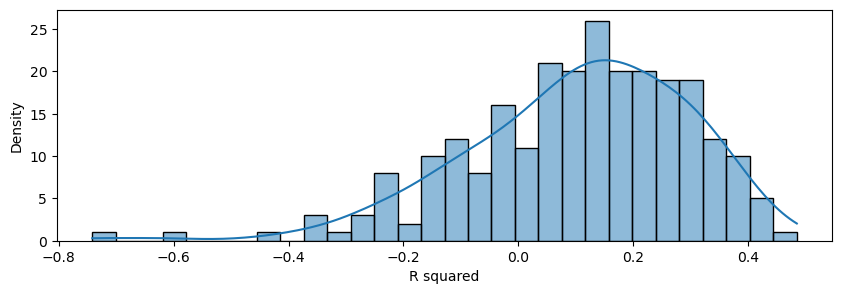

In [208]:
# Plot the r squared
bootstrapped_r2 = compute_rsquared(y_valid, y_pred_mean)
print(f"Bootstrapped R^2: {bootstrapped_r2}")

plt.figure(figsize=(10, 3))
sns.histplot(rsquared_bootstrap, bins=30, kde=True)
plt.xlabel("R squared")
plt.ylabel("Density")
plt.show()

In [209]:
# Plot the predictions per country, per date
def plot_by_country(selected_country):
    plt.figure(figsize=(15, 5))
    plt.plot(y_valid[country_valid == selected_country], label="True")
    plt.plot(y_pred_mean[country_valid == selected_country], label="Predicted")
    plt.plot(y_pred_median[country_valid == selected_country], label="Predicted (median)")
    plt.plot(y_pred_best[country_valid == selected_country], label="Predicted (best)")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - 3 * y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + 3 * y_pred_std[country_valid == selected_country], alpha=0.05, color="red")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - 1.96 * y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + 1.96 * y_pred_std[country_valid == selected_country], alpha=0.2)
    plt.xlabel("Date")
    plt.ylabel("GDP")
    plt.title(f"{selected_country}")
    plt.legend()

interact(plot_by_country, selected_country=np.unique(country_valid))

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

<function __main__.plot_by_country(selected_country)>

In [210]:
# THIS IS BASED ONLY ON THE FIRST MODEL !! NOT THE BOOTSTRAP MODELS

# Get the predictions
x_valid = torch.tensor(x_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [211]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [212]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [213]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('United States', 'Canada', 'Korea', 'United Ki…

In [214]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[(predictions_melted["country"] == selected_country) & (predictions_melted["Set"] == "Validation")]
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('United States', 'Canada', 'Korea', 'United Ki…